In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import u_momentum, v_momentum, get_rhs, get_coeff_mat_modified, pres_correct, update_velocity, check_divergence_free

imax = 20                        # grid size in x-direction
jmax = 20                        # grid size in y-direction
max_iteration = 6000
maxRes = 1000
# iteration = 10
mu = 0.01                        # viscosity
rho = 1                          # density
velocity = 1                     # velocity = lid velocity
dx = 1 / (imax - 1)              # dx, dy cell sizes along x and y directions
dy = 1 / (jmax - 1)
x = np.arange(dx / 2, 1 + dx/2 - dx / 2, dx)
y = np.arange(0, 1+dy/2, dy)
alphaP = 0.1                     # pressure under-relaxation
alphaU = 0.7                     # velocity under-relaxation
tol = 1e-5

In [2]:
# Variable declaration
p = np.zeros((imax, jmax))             # p = Pressure
p_star = np.zeros((imax, jmax))
p_prime = np.zeros((imax, jmax))       # pressure correction
rhsp = np.zeros((imax, jmax))          # Right hand side vector of pressure correction equation
divergence = np.zeros((imax, jmax))

# Vertical velocity
v_star = np.zeros((imax, jmax + 1))
vold = np.zeros((imax, jmax + 1))
vRes = np.zeros((imax, jmax + 1))
v = np.zeros((imax, jmax + 1))
d_v = np.zeros((imax, jmax + 1))       # velocity correction coefficient

# Horizontal Velocity
u_star = np.zeros((imax + 1, jmax))
uold = np.zeros((imax + 1, jmax))
uRes = np.zeros((imax + 1, jmax))
u = np.zeros((imax + 1, jmax))
d_u = np.zeros((imax + 1, jmax))       # velocity correction coefficient

In [3]:
# Boundary condition
# Lid velocity (Top wall is moving with 1m/s)
u_star[:, jmax-1] = velocity
u[:, jmax-1] = velocity

In [4]:
iteration = 1
# max_iteration = 1
while iteration <= max_iteration and maxRes > tol:
    iteration += 1
    u_star, d_u = u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, velocity, alphaU)
    v_star, d_v = v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, alphaU)

    uold = u.copy()
    vold = v.copy()

    rhsp = get_rhs(imax, jmax, dx, dy, rho, u_star, v_star)
    Ap = get_coeff_mat_modified(imax, jmax, dx, dy, rho, d_u, d_v)
    p, p_prime = pres_correct(imax, jmax, rhsp, Ap, p_star, alphaP)
    u, v = update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity)
    divergence = check_divergence_free(imax, jmax, dx, dy, u, v)

    p_star = p.copy()

    vRes = np.abs(v - vold)
    uRes = np.abs(u - uold)
    maxRes_u = np.max(uRes)
    maxRes_v = np.max(vRes)
    maxRes = max(maxRes_u, maxRes_v)

    print(f"It = {iteration}; Res = {maxRes}")
    if maxRes > 2:
        print("not going to converge!")
        break

It = 2; Res = 0.14148608929581347
It = 3; Res = 0.11037314609766719
It = 4; Res = 0.06333556800582862
It = 5; Res = 0.05179213200172633
It = 6; Res = 0.03724158404138933
It = 7; Res = 0.03145317568214573
It = 8; Res = 0.025317540369106772
It = 9; Res = 0.022433914553052076
It = 10; Res = 0.020186805303783112
It = 11; Res = 0.018562038622414928
It = 12; Res = 0.01687308598505438
It = 13; Res = 0.015489095709350004
It = 14; Res = 0.014176360042126912
It = 15; Res = 0.013039189521700523
It = 16; Res = 0.011992358347604759
It = 17; Res = 0.011061129551586557
It = 18; Res = 0.010210949186040708
It = 19; Res = 0.009444085628585286
It = 20; Res = 0.008744287843766796
It = 21; Res = 0.008107896924271552
It = 22; Res = 0.0075258869750705615
It = 23; Res = 0.006993734595927614
It = 24; Res = 0.0065866718522365475
It = 25; Res = 0.006251175277072085
It = 26; Res = 0.0059307499911786105
It = 27; Res = 0.0056256365761550575
It = 28; Res = 0.005335568653666384
It = 29; Res = 0.0050602789825652805
It

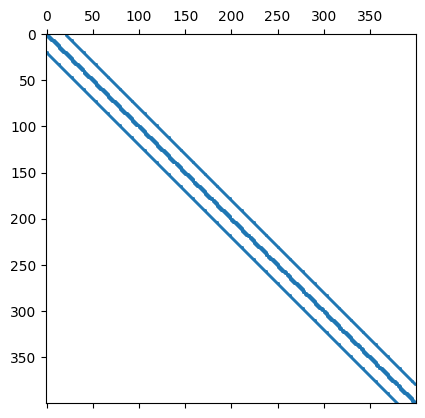

In [5]:
# Check sparse pattern
plt.spy(Ap, markersize=1)

In [6]:
print("Condition Number = ", np.linalg.cond(Ap))
# print("Stability from sparse and dense solver:" ,np.linalg.norm(np.linalg.solve(Ap, rhsp)-sparse.linalg.spsolve(Ap, rhsp)))

Condition Number =  12653.141857559705


Total Iterations = 246


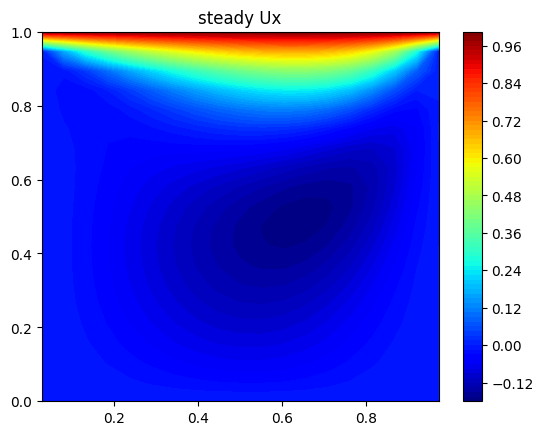

In [7]:
print(f"Total Iterations = {iteration}")
X, Y = np.meshgrid(x, y)
plt.figure()
plt.contourf(X, Y, u[1:imax,:].T, 100, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title('steady Ux')
plt.show()


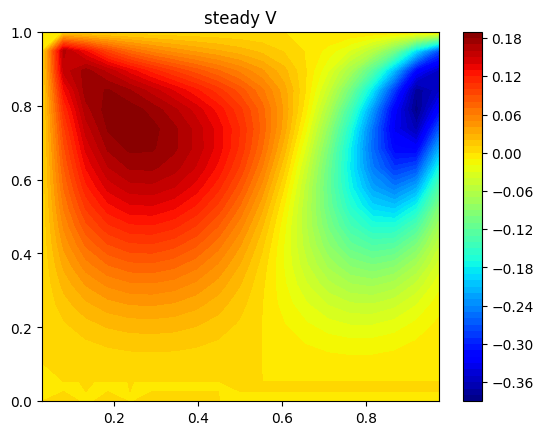

In [8]:
plt.figure()
plt.contourf(X, Y, v[0:imax-1, 0:jmax].T, 60, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title('steady V')
plt.show()

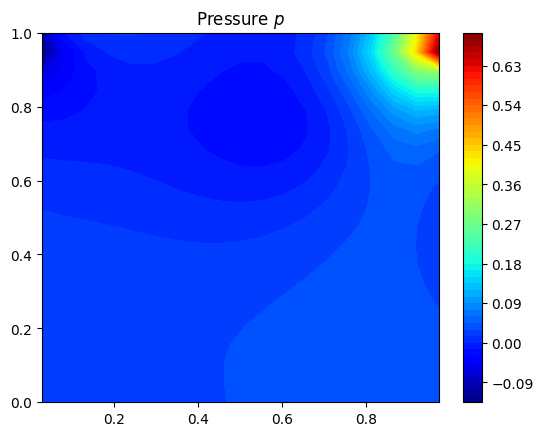

In [9]:
plt.figure()
plt.contourf(X, Y, p[1:imax, 0:jmax+1].T, 60, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title('Pressure $p$')
plt.show()

Benchmark with the Spectral Method: